In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score

In [27]:
df = pd.read_csv("data/processed/happiness_final.csv") 
df.head(5)

,Happiness_Rank,Country,Happiness_Score,GDP_per_Capita,Social_Support,Life_Expectancy,Freedom,Government_Corruption,Generosity,Year
0,153,Afghanistan,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,2015
1,154,Afghanistan,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2016
2,141,Afghanistan,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2017
3,145,Afghanistan,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2018
4,154,Afghanistan,3.203,0.350000,0.517000,0.361000,0.00000,0.025000,0.158000,2019


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Happiness_Rank         782 non-null    int64  
 1   Country                782 non-null    object 
 2   Happiness_Score        782 non-null    float64
 3   GDP_per_Capita         782 non-null    float64
 4   Social_Support         782 non-null    float64
 5   Life_Expectancy        782 non-null    float64
 6   Freedom                782 non-null    float64
 7   Government_Corruption  782 non-null    float64
 8   Generosity             782 non-null    float64
 9   Year                   782 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 61.2+ KB


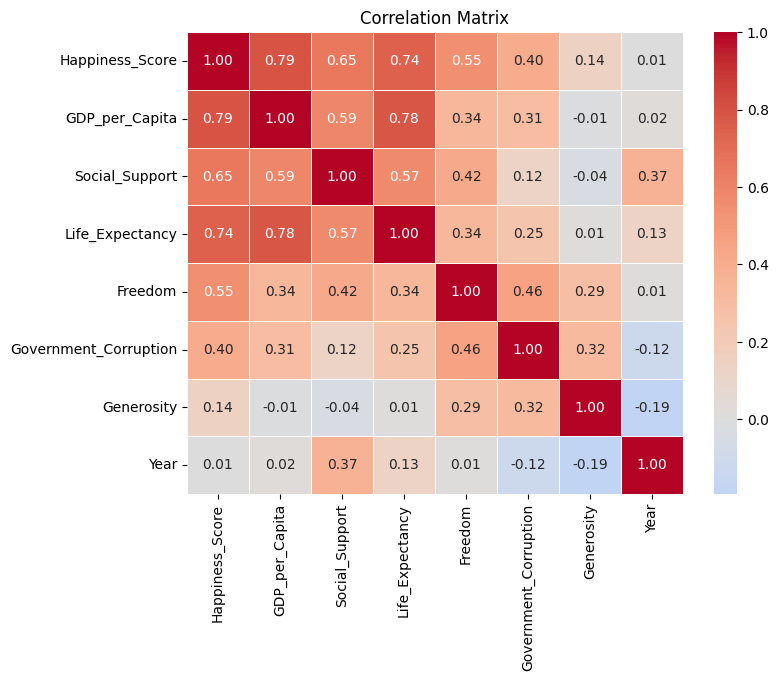

In [29]:
plt.figure(figsize=(8,6))
corr_matrix = df[[
    "Happiness_Score",
    "GDP_per_Capita",
    "Social_Support",
    "Life_Expectancy",
    "Freedom",
    "Government_Corruption",
    "Generosity",
    "Year"
]].corr()

sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm', center=0,
    linewidths=0.5, fmt=".2f"
)
plt.title("Correlation Matrix")
plt.show()


In [30]:
X = df[[
    "GDP_per_Capita",
    "Social_Support",
    "Life_Expectancy",
    "Freedom",
    "Government_Corruption",
    "Generosity",
    "Year"
]]
y = df["Happiness_Score"]

print(f"Observaciones totales: {len(df)}")

Observaciones totales: 782


In [31]:
X_ols = sm.add_constant(X)
modelo = sm.OLS(y, X_ols).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:        Happiness_Score   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     375.1
Date:                Fri, 07 Nov 2025   Prob (F-statistic):          9.15e-244
Time:                        23:19:45   Log-Likelihood:                -624.32
No. Observations:                 782   AIC:                             1265.
Df Residuals:                     774   BIC:                             1302.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   168.81

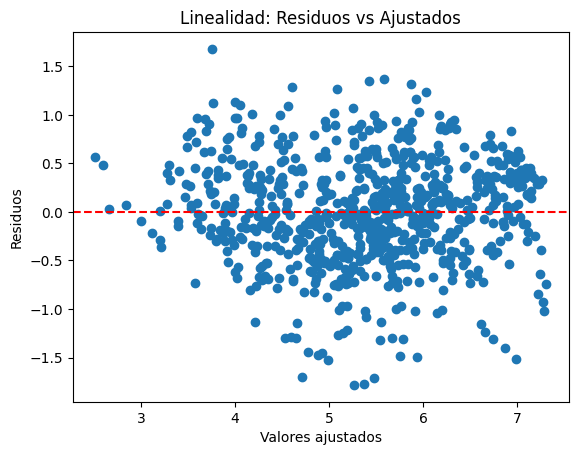

In [32]:
plt.scatter(modelo.fittedvalues, modelo.resid)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Linealidad: Residuos vs Ajustados")
plt.show()

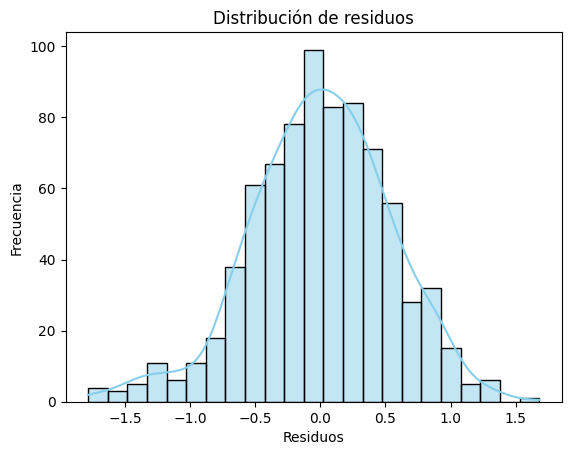

In [33]:
sns.histplot(modelo.resid, kde=True, color='skyblue')
plt.title("Distribución de residuos")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()

In [34]:
shapiro_test = stats.shapiro(modelo.resid)
ad_test = normal_ad(modelo.resid)
print(f"Shapiro-Wilk: p={shapiro_test.pvalue:.4f}")
print(f"Anderson-Darling: p={ad_test[1]:.4f}")

Shapiro-Wilk: p=0.0004
Anderson-Darling: p=0.0156


In [35]:
vif = pd.DataFrame()
vif["Variable"] = X_ols.columns
vif["VIF"] = [variance_inflation_factor(X_ols.values, i) for i in range(X_ols.shape[1])]
print(vif)

                Variable           VIF
0                  const  2.666522e+06
1         GDP_per_Capita  3.147312e+00
2         Social_Support  2.200239e+00
3        Life_Expectancy  2.787140e+00
4                Freedom  1.619626e+00
5  Government_Corruption  1.444334e+00
6             Generosity  1.221684e+00
7                   Year  1.316452e+00


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
n, k = X_test.shape

results = []

def model_eval(nombre, y_test, y_pred, n, k):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    aic = n * np.log(mse) + 2 * (k + 1)
    bic = n * np.log(mse) + (k + 1) * np.log(n)
    return [nombre, r2, rmse, mape, aic, bic]

ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)
results.append(model_eval("OLS", y_test, y_pred_ols, n, k))

ridge = RidgeCV(alphas=np.arange(0.01, 1, 0.05), cv=5).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
results.append(model_eval("Ridge", y_test, y_pred_ridge, n, k))

lasso = LassoCV(alphas=np.arange(0.001, 1, 0.01), cv=5, n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
results.append(model_eval("Lasso", y_test, y_pred_lasso, n, k))

elastic = ElasticNetCV(alphas=np.arange(0.001, 1, 0.01),
                       l1_ratio=np.arange(0.1, 1, 0.1),
                       cv=5, n_jobs=-1, random_state=42).fit(X_train, y_train)
y_pred_elastic = elastic.predict(X_test)
results.append(model_eval("ElasticNet", y_test, y_pred_elastic, n, k))

df_results = pd.DataFrame(results, columns=["Modelo", "R²", "RMSE", "MAPE", "AIC", "BIC"])
df_results = df_results.round(4).sort_values("R²", ascending=False).reset_index(drop=True)
display(df_results)

,Modelo,R²,RMSE,MAPE,AIC,BIC
0,OLS,0.7608,0.5351,0.0839,-277.8695,-250.1928
1,Lasso,0.7608,0.5351,0.0840,-277.8710,-250.1943
2,ElasticNet,0.7606,0.5354,0.0840,-277.6488,-249.9721
3,Ridge,0.7603,0.5357,0.0841,-277.3750,-249.6983


In [37]:
best_model_name = df_results.loc[df_results["R²"].idxmax(), "Modelo"]
print(f"Mejor modelo: {best_model_name}")

if best_model_name == "OLS":
    best_model = ols
elif best_model_name == "Ridge":
    best_model = ridge
elif best_model_name == "Lasso":
    best_model = lasso
else:
    best_model = elastic

joblib.dump(best_model, f"model/{best_model_name}_Model.pkl")
print(f"Modelo guardado como: {best_model_name}_Model.pkl")

Mejor modelo: OLS
Modelo guardado como: OLS_Model.pkl


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Predicciones
y_train_pred = best_model.predict(X_train)
y_test_pred  = best_model.predict(X_test)

# Métricas
r2_train = r2_score(y_train, y_train_pred)
r2_test  = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test  = np.sqrt(mean_squared_error(y_test, y_test_pred))
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test  = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"R² train: {r2_train:.4f} | R² test: {r2_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")
print(f"MAPE train: {mape_train:.4f} | MAPE test: {mape_test:.4f}")

R² train: 0.7714 | R² test: 0.7665
RMSE train: 0.5417 | RMSE test: 0.5322
MAPE train: 0.0838 | MAPE test: 0.0850


In [40]:
scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print(f"R² promedio (5 folds): {scores.mean():.4f} ± {scores.std():.4f}")

R² promedio (5 folds): 0.7389 ± 0.0635


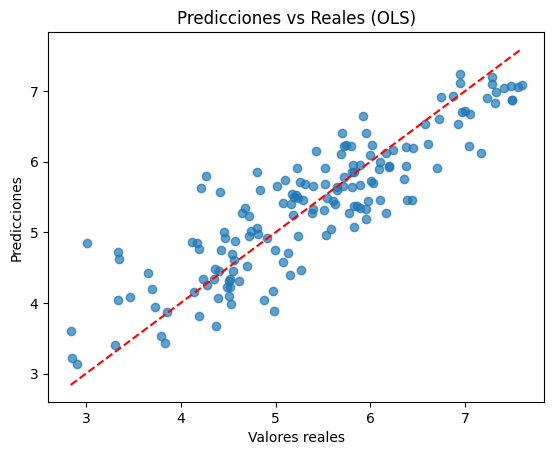

In [41]:
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title(f"Predicciones vs Reales ({best_model_name})")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

ShapiroResult(statistic=np.float64(0.9779390881295082), pvalue=np.float64(0.012834188628013238))

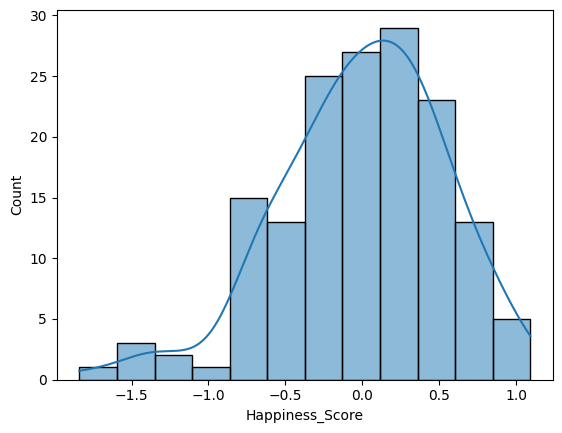

In [42]:
residuos = y_test - y_test_pred
sns.histplot(residuos, kde=True)
stats.shapiro(residuos)

In [43]:
# Predictions and residuals
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

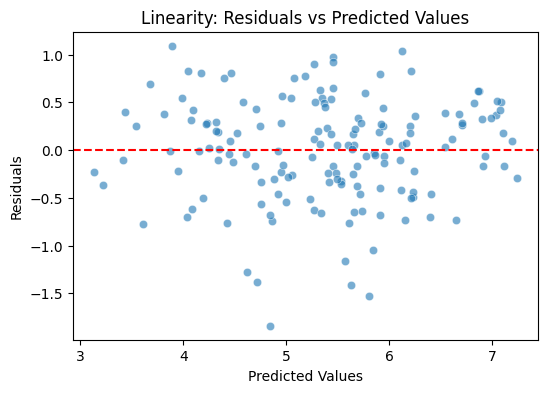

In [44]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Linearity: Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


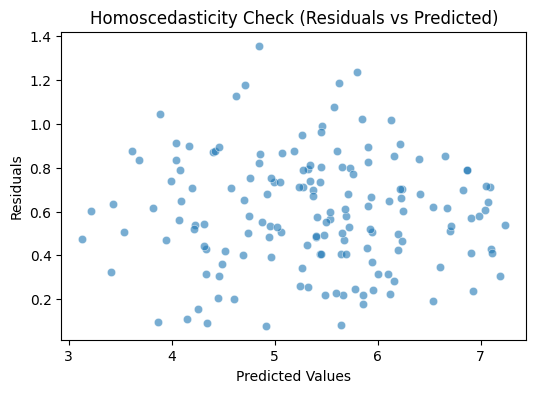

In [45]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=np.sqrt(abs(residuals)), alpha=0.6)
plt.title("Homoscedasticity Check (Residuals vs Predicted)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

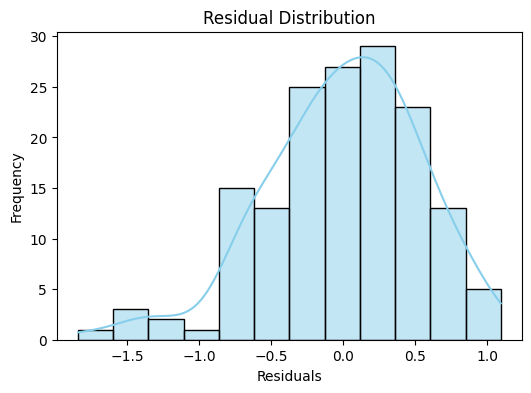

In [46]:
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, color='skyblue')
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

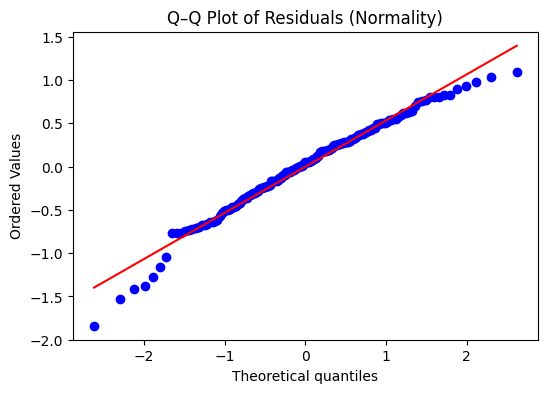

In [47]:
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals (Normality)")
plt.show()


Variance Inflation Factor (VIF):
                 Feature           VIF
0                  const  2.666522e+06
1         GDP_per_Capita  3.147312e+00
2         Social_Support  2.200239e+00
3        Life_Expectancy  2.787140e+00
4                Freedom  1.619626e+00
5  Government_Corruption  1.444334e+00
6             Generosity  1.221684e+00
7                   Year  1.316452e+00


C:\Users\kelly\AppData\Local\Temp\ipykernel_41880\2395241248.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_data.iloc[1:], x="VIF", y="Feature", palette="Blues_r")


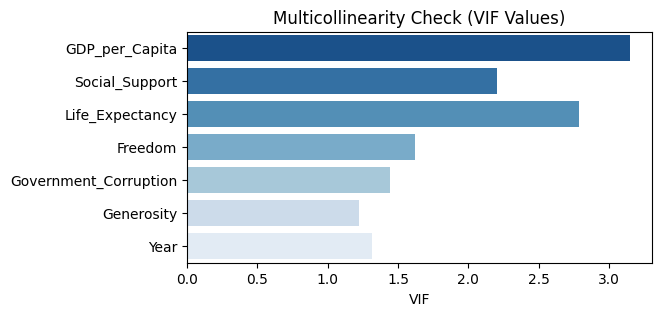

In [48]:
X_vif = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print("\nVariance Inflation Factor (VIF):")
print(vif_data)

# Optional visualization of VIF
plt.figure(figsize=(6, 3))
sns.barplot(data=vif_data.iloc[1:], x="VIF", y="Feature", palette="Blues_r")
plt.title("Multicollinearity Check (VIF Values)")
plt.xlabel("VIF")
plt.ylabel("")
plt.show()